| Етап (UKR)                     | Задачі (UKR)                                                                                                                                                                                                                         | Stage (ENG)                      | Tasks (ENG)                                                                                                                                                                                                                                                   |
| ------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | -------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1. Підготовка даних            | • Завантажити датасет «Signs (Fingers)»<br>• Розбити на train/validation/test<br>• Нормалізувати пікселі (0–1)<br>• One‑hot кодування міток                                                                                          | 1. Data Preparation              | • Load the “Signs (Fingers)” dataset<br>• Split into train/validation/test sets<br>• Normalize pixel values (0–1)<br>• One‑hot encode the labels                                                                                                              |
| 2. Базова модель               | • Сконструювати просту MLP/CNN <br>• Визначити критерій зупинки та метрики (accuracy, loss)                                                                                             | 2. Baseline Model                | • Construct a simple MLP/CNN <br>• Define stopping criterion and metrics (accuracy, loss)                                                                                                                            |
| 3. Дослідження гіперпараметрів | • **Кількість шарів:** моделі з 1, 2, 3 Dense/CNN‑шарів (ReLU, Dropout=0.2)<br>• **Активація:** для 2‑шарової архітектури ReLU vs tanh vs sigmoid (Dropout=0.2)<br>• **Dropout:** для оптимальної конфігурації Dropout=0.0, 0.2, 0.5 | 3. Hyperparameter Exploration    | • **Number of layers:** models with 1, 2, and 3 Dense/CNN layers (ReLU, Dropout=0.2)<br>• **Activation:** compare ReLU vs tanh vs sigmoid on 2‑layer architecture (Dropout=0.2)<br>• **Dropout ratio:** test Dropout=0.0, 0.2, 0.5 for the best configuration |
| 4. Аналіз результатів          | • Визначити найкращу конфігурацію за валідаційною accuracy<br>• Оцінити модель на тестовій вибірці<br>• Провести аналіз помилок (confusion matrix)                                                                                   | 4. Results Analysis              | • Identify the best configuration by validation accuracy<br>• Evaluate the model on the held‑out test set<br>• Perform error analysis (confusion matrix)                                                                                                      |
| 5. Висновки й рекомендації     | • Зробити висновки щодо впливу гіперпараметрів на збіжність та якість<br>• Сформулювати рекомендації для подальших експериментів                                                                                                     | 5. Conclusions & Recommendations | • Draw insights on how each hyperparameter affects convergence and performance<br>• Formulate recommendations for future experiments                                                                                                                          |

---
### **Основна ціль домашнього завдання (UKR) / Main objective of the homework (ENG) :**
- Логічно спроектувати та реалізувати нейронну мережу для класифікації датасету «Signs (Fingers)», дослідити вплив гіперпараметрів (глибина мережі, функція активації, рівень Dropout) шляхом серії експериментів, і надати звіт із порівнянням результатів (validation accuracy, loss, графіки збіжності, confusion matrix).

- Logically design and implement a neural network for the “Signs (Fingers)” classification dataset, investigate the impact of hyperparameters (network depth, activation function, dropout ratio) through a series of experiments, and deliver a report comparing results (validation accuracy, loss, convergence plots, confusion matrix).

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
def load_dataset():
    fn = '/Users/vladislavpleshko/Documents/VS Code/before/amazinum/data/Train Signs.h5'
    train_dataset = h5py.File(fn, "r")
    X_train = np.array(train_dataset["train_set_x"][:]) # your train set features
    Y_train = np.array(train_dataset["train_set_y"][:]) # your train set labels

    fn = '/Users/vladislavpleshko/Documents/VS Code/before/amazinum/data/Test Signs.h5'
    test_dataset =  h5py.File(fn, "r")
    X_test = np.array(test_dataset["test_set_x"][:]) # your test set features
    Y_test = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    Y_train = Y_train.reshape((1, Y_train.shape[0]))
    Y_test = Y_test.reshape((1, Y_test.shape[0]))

    return X_train, Y_train, X_test, Y_test, classes
train_data, train_labels, test_data, test_labels, classes = load_dataset()

print ('train_data.shape=', train_data.shape)
print ('train_labels.shape=',  train_labels.shape)
print ('test_data.shape=', test_data.shape)
print ('test_labels.shape=', test_labels.shape)


train_data.shape= (1080, 64, 64, 3)
train_labels.shape= (1, 1080)
test_data.shape= (120, 64, 64, 3)
test_labels.shape= (1, 120)


In [3]:
def display_samples_in_grid(X, n_rows, n_cols= None, y = None ):
    if n_cols is None:
        n_cols= n_rows
    indices = np.random.randint(0, len(X),n_rows*n_cols)
    for i in range (n_rows):
        for j in range (n_cols):
            index = n_cols*i+j
            ax = plt.subplot(n_rows,n_cols,index+1)
            ax.imshow(X[indices[index]], cmap='Greys')
            if not (y is None):
                plt.title(y[indices[index]])
            plt.axis('off')


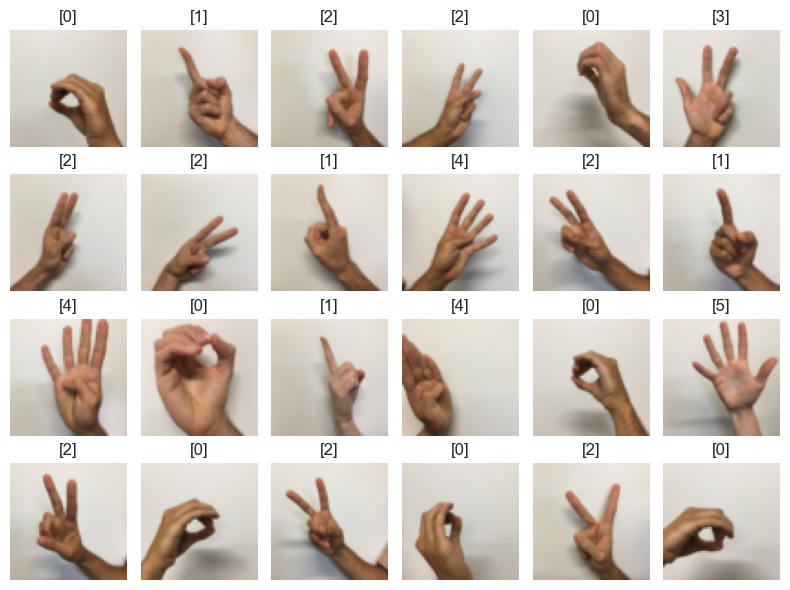

In [4]:
plt.figure(figsize=(8,6))
display_samples_in_grid(train_data, n_rows=4, n_cols=6, y=train_labels.T)
plt.tight_layout(h_pad=1, w_pad=1)


## Основні практичні випадки нормалізації пікселів

| Джерело даних                                            | Тип              | Діапазон       | Нормалізація                                       |
| -------------------------------------------------------- | ---------------- | -------------- | -------------------------------------------------- |
| Стандартне PNG/JPEG зображення                           | uint8            | 0–255          | /255.0                                             |
| Медичні DICOM або TIFF                                   | uint16           | 0–65535        | /65535.0                                           |
| RAW-зображення з телескопа                               | uint16 або int16 | -32 768…32 767 | / 32 767.0 або власна нормалізація                 |
| Зображення, зчитані tf.keras.datasets (наприклад, MNIST) | uint8            | 0–255          | /255.0                                             |
| TFDS (TensorFlow datasets)                               | float32          | 0–1 або -1 … 1 | Часто вже нормалізовані                            |
| Spectrogram аудіо                                        | float32          | різне          | Часто нормалізують у \[-1, 1] або 0 mean, unit std |


In [5]:
def inspect_image_data(data):
    print(f'Data type: {data.dtype}')
    print(f'Min pixel value: {np.min(data)}')
    print(f'Max pixel value: {np.max(data)}')

inspect_image_data(train_data)


Data type: uint8
Min pixel value: 4
Max pixel value: 244


In [6]:
X_train = train_data/255.0
X_test = test_data/255.0

inspect_image_data(X_train), inspect_image_data(X_test)


Data type: float64
Min pixel value: 0.01568627450980392
Max pixel value: 0.9568627450980393
Data type: float64
Min pixel value: 0.011764705882352941
Max pixel value: 0.9450980392156862


(None, None)

| Числове значення | Для людини | Для моделі          |
| ---------------- | ---------- | ------------------- |
| 3                | клас №3    | \[0, 0, 0, 1, 0, 0] |
| 1                | клас №1    | \[0, 1, 0, 0, 0, 0] |
| 0                | клас №0    | \[1, 0, 0, 0, 0, 0] |


In [7]:
train_labels.shape, test_labels.shape


((1, 1080), (1, 120))

In [8]:
y_train_flat = train_labels.flatten()
y_test_flat = test_labels.flatten()

print(y_train_flat.shape, y_test_flat.shape)
print(np.unique(y_train_flat))
print(len(np.unique(y_train_flat)))
print(classes)


(1080,) (120,)
[0 1 2 3 4 5]
6
[0 1 2 3 4 5]


In [9]:
from tensorflow.keras.utils import to_categorical # type: ignore

y_train_oh = to_categorical(y_train_flat)
y_test_oh = to_categorical(y_test_flat)

print(y_train_oh.shape)
print(y_test_oh.shape)

print(y_train_oh[0])


2025-07-11 14:22:57.538117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(1080, 6)
(120, 6)
[0. 0. 0. 0. 0. 1.]


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, CSVLogger  # type: ignore


In [11]:
INPUT_SHAPE = train_data.shape[1:]

print(INPUT_SHAPE)


(64, 64, 3)


In [12]:
static_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
static_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


In [14]:
static_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,926 (6.20 MB)

 Trainable params: 1,625,926 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = static_model.fit(X_train, y_train_oh,
                           epochs=30,
                           batch_size=32,
                           validation_data=(X_test, y_test_oh),
                           verbose=1)


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.1676 - loss: 2.0605 - val_accuracy: 0.2500 - val_loss: 1.7911
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.1994 - loss: 1.7807 - val_accuracy: 0.2667 - val_loss: 1.7217
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.3129 - loss: 1.6570 - val_accuracy: 0.5333 - val_loss: 1.3133
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5205 - loss: 1.2691 - val_accuracy: 0.6667 - val_loss: 1.0724
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.5864 - loss: 1.0974 - val_accuracy: 0.7667 - val_loss: 0.8911
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.6464 - loss: 0.9429 - val_accuracy: 0.8000 - val_loss: 0.7677
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6706 - loss: 0.8561 - val_accuracy: 0.8167 - val_loss: 0.7189
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7387 - loss: 0.7138 - val_accuracy: 0.

In [16]:
test_loss, test_accuracy = static_model.evaluate(X_test, y_test_oh, verbose=1)
print('Accuracy:', test_accuracy)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9569 - loss: 0.1725
Accuracy: 0.9416666626930237


In [17]:
historydata = history.history
# history.__dict__


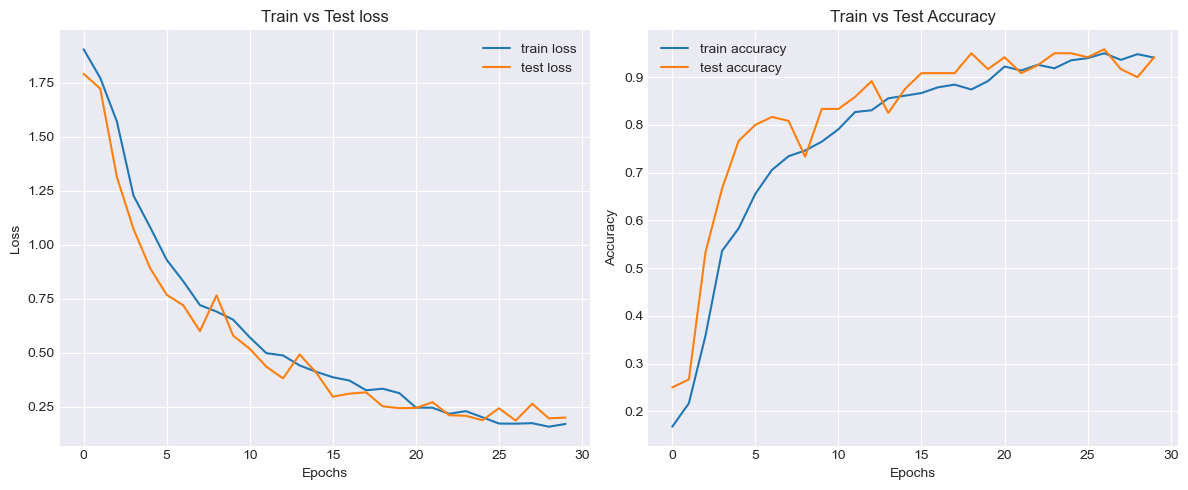

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(historydata['loss'], label='train loss')
plt.plot(historydata['val_loss'], label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(historydata['accuracy'], label='train accuracy')
plt.plot(historydata['val_accuracy'], label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
# Отримуємо передбачення для тестових даних
y_pred_proba = static_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

y_pred


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


array([0, 0, 0, 5, 1, 0, 3, 1, 5, 1, 5, 1, 3, 1, 1, 3, 5, 4, 0, 4, 5, 4,
       2, 5, 3, 5, 4, 2, 1, 2, 3, 1, 0, 3, 1, 1, 0, 3, 2, 3, 0, 3, 0, 2,
       3, 1, 1, 2, 0, 3, 4, 1, 2, 0, 4, 0, 4, 0, 4, 4, 5, 4, 2, 4, 4, 5,
       0, 1, 3, 5, 0, 5, 1, 2, 3, 4, 3, 5, 1, 5, 2, 0, 1, 3, 2, 4, 4, 1,
       4, 5, 5, 0, 0, 5, 5, 5, 3, 5, 5, 2, 2, 2, 0, 2, 4, 3, 0, 2, 3, 4,
       1, 3, 2, 4, 2, 2, 1, 3, 1, 3])

In [20]:
y_true = np.argmax(y_test_oh, axis=1)
y_true


array([0, 0, 0, 5, 1, 0, 3, 1, 5, 1, 5, 1, 3, 1, 1, 3, 5, 4, 0, 4, 5, 4,
       2, 5, 3, 5, 4, 2, 1, 2, 3, 1, 0, 3, 1, 1, 0, 4, 2, 3, 0, 3, 0, 2,
       3, 1, 2, 2, 0, 3, 4, 1, 2, 0, 4, 0, 4, 0, 4, 4, 5, 5, 2, 4, 4, 5,
       0, 1, 3, 5, 0, 4, 1, 2, 3, 4, 3, 5, 1, 5, 2, 0, 1, 4, 2, 4, 4, 1,
       4, 5, 5, 0, 0, 5, 5, 5, 3, 3, 5, 2, 2, 2, 0, 2, 5, 3, 0, 2, 3, 4,
       1, 3, 2, 4, 2, 2, 1, 3, 1, 3])

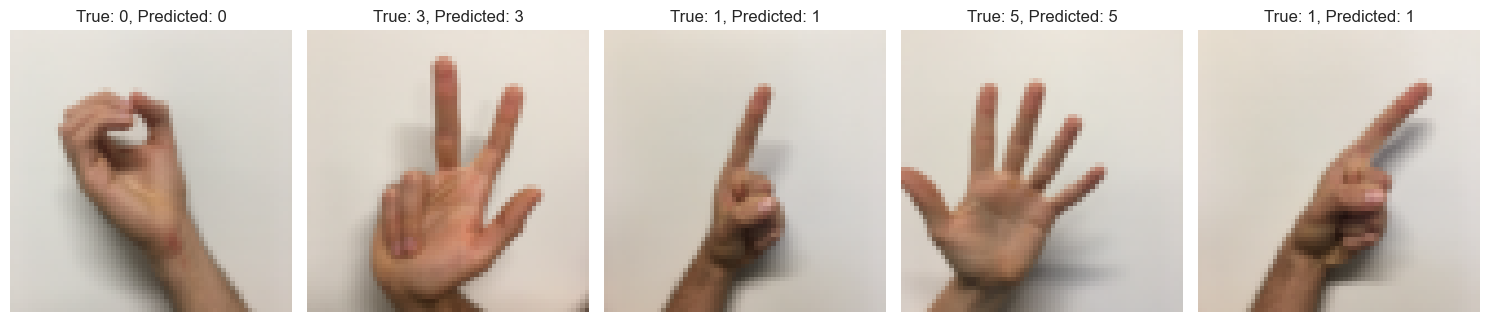

In [21]:
plt.figure(figsize=(15,10))
for i in range(5,10):
    plt.subplot(2,5, i+1)
    plt.imshow(X_test[i])
    plt.title(f"True: {y_true[i]}, Predicted: {y_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


 ## **Experimental block**

### Основна ціль блоку:
1. Змінити кількість hidden layers (1, 2, 3).
Для кожного варіанту змінити активацію:
    - relu
    - tanh
    - sigmoid

2. Для кожної конфігурації протестувати різний Dropout (0.0, 0.2, 0.5).
3. Порівняти результати: чи краще модель навчається, чи гірше, чи переобучається (дивитись на accuracy та loss).

### Складові експериментльного блоку \ функції
- 1. Послідовна прогонка тренування моделі на різних гіперпараметрах
- 2. Запис та збереження результатів якості тренувань
    - візуалізація

In [ ]:
import time


In [23]:
activations = ['relu', 'tanh', 'sigmoid']
n_layers = [1, 2, 3]
dropouts = [0.0, 0.25, 0.5]


In [ ]:
total_config = len(activations) * len(n_layers) * len(dropouts)

for i, a in enumerate(activations):
    for j, n in enumerate(n_layers):
        for k, d in enumerate(dropouts):
            global_ix = i * len(n_layers) * len(dropouts) + j * len(dropouts) + k + 1
            print(f'Config [{global_ix}/{total_config}]: act={a}, h.layers={n}, dropout={d}')


Config [1/27]: act=relu, h.layers=1, dropout=0.0
Config [2/27]: act=relu, h.layers=1, dropout=0.25
Config [3/27]: act=relu, h.layers=1, dropout=0.5
Config [4/27]: act=relu, h.layers=2, dropout=0.0
Config [5/27]: act=relu, h.layers=2, dropout=0.25
Config [6/27]: act=relu, h.layers=2, dropout=0.5
Config [7/27]: act=relu, h.layers=3, dropout=0.0
Config [8/27]: act=relu, h.layers=3, dropout=0.25
Config [9/27]: act=relu, h.layers=3, dropout=0.5
Config [10/27]: act=tanh, h.layers=1, dropout=0.0
Config [11/27]: act=tanh, h.layers=1, dropout=0.25
Config [12/27]: act=tanh, h.layers=1, dropout=0.5
Config [13/27]: act=tanh, h.layers=2, dropout=0.0
Config [14/27]: act=tanh, h.layers=2, dropout=0.25
Config [15/27]: act=tanh, h.layers=2, dropout=0.5
Config [16/27]: act=tanh, h.layers=3, dropout=0.0
Config [17/27]: act=tanh, h.layers=3, dropout=0.25
Config [18/27]: act=tanh, h.layers=3, dropout=0.5
Config [19/27]: act=sigmoid, h.layers=1, dropout=0.0
Config [20/27]: act=sigmoid, h.layers=1, dropout=0

In [ ]:
def create_cnn_model(activation, dropout, conv_layers):

    model = Sequential()
    model.add(Conv2D(32,(3,3), activation=activation, input_shape=(INPUT_SHAPE)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout))

    for i in range(1, conv_layers):
        filters = 32 * (i + 1)
        model.add(Conv2D(filters,(3,3), activation=activation))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(6, activation='softmax'))
    return model

early_stop = EarlyStopping(
    monitor='val_loss',        # Що відстежувати (наприклад, 'val_loss', 'val_accuracy')
    patience=5,                # Скільки епох чекати без покращення, перш ніж зупинити тренування
    min_delta=0.0,             # Мінімальна зміна, яку вважаємо покращенням (ігнорує дрібні коливання)
    mode='auto',               # 'min', 'max' або 'auto' — як інтерпретувати покращення (мінімізація чи максимізація)
    restore_best_weights=False,# Якщо True — після зупинки повертає ваги з найкращої епохи
    verbose=1,                 # 1 — виводити повідомлення про зупинку, 0 — тихо
    baseline=None,             # Якщо задано — тренування зупиниться, якщо метрика не покращиться відносно цього значення
    start_from_epoch=0         # З якої епохи почати відстеження (можна пропустити початковий "розгін")
)


In [62]:
results = []

total_config = len(activations) * len(n_layers) * len(dropouts)

for i, activation in enumerate(activations):
    for j, layer in enumerate(n_layers):
        for k, dropout in enumerate(dropouts):
            global_ix = i * len(n_layers) * len(dropouts) + j * len(dropouts) + k + 1

            model = create_cnn_model(activation=activation, dropout=dropout, conv_layers=layer)
            model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy']
                        )
            start_time = time.time()
            history = model.fit(X_train, y_train_oh,
                                epochs=30,
                                batch_size=32,
                                validation_data=(X_test, y_test_oh),
                                verbose=0,
                                callbacks=[early_stop])
            elapsed_time = time.time() - start_time
            val_acc = history.history['val_accuracy'][-1]
            train_acc = history.history['accuracy'][-1]
            results.append({
                'activation': activation,
                'dropout': dropout,
                'hidden_layers': layer,
                'val_accuracy': val_acc,
                'train_accuracy': train_acc
            })
            print(f'Config [{global_ix}/{total_config}]: Activation: {activation}, Layers: {layer}, Dropout: {dropout} = Train/valid. acc: {train_acc:.2f}/{val_acc:.2f} ({elapsed_time:.1f} sec.)')

results_df = pd.DataFrame(results)


Config [1/27]: Activation: relu, Layers: 1, Dropout: 0.0 = Train/valid. acc: 1.00/0.94 (67.5 sec.)
Config [2/27]: Activation: relu, Layers: 1, Dropout: 0.25 = Train/valid. acc: 0.92/0.86 (78.9 sec.)
Epoch 6: early stopping
Config [3/27]: Activation: relu, Layers: 1, Dropout: 0.5 = Train/valid. acc: 0.15/0.17 (18.0 sec.)
Epoch 18: early stopping
Config [4/27]: Activation: relu, Layers: 2, Dropout: 0.0 = Train/valid. acc: 1.00/0.93 (51.2 sec.)
Epoch 26: early stopping
Config [5/27]: Activation: relu, Layers: 2, Dropout: 0.25 = Train/valid. acc: 0.99/0.92 (99.4 sec.)
Config [6/27]: Activation: relu, Layers: 2, Dropout: 0.5 = Train/valid. acc: 0.73/0.87 (106.7 sec.)
Epoch 24: early stopping
Config [7/27]: Activation: relu, Layers: 3, Dropout: 0.0 = Train/valid. acc: 1.00/0.95 (81.4 sec.)
Epoch 29: early stopping
Config [8/27]: Activation: relu, Layers: 3, Dropout: 0.25 = Train/valid. acc: 0.95/0.92 (116.9 sec.)
Config [9/27]: Activation: relu, Layers: 3, Dropout: 0.5 = Train/valid. acc: 0.

In [63]:
results_df.sort_values('activation')


,activation,dropout,hidden_layers,val_accuracy,train_accuracy
0,relu,0.00,1,0.941667,1.000000
1,relu,0.25,1,0.858333,0.916667
2,relu,0.50,1,0.166667,0.150926
3,relu,0.00,2,0.933333,1.000000
4,relu,0.25,2,0.916667,0.985185
5,relu,0.50,2,0.866667,0.726852
6,relu,0.00,3,0.950000,1.000000
7,relu,0.25,3,0.916667,0.954630
8,relu,0.50,3,0.941667,0.887963
24,sigmoid,0.00,3,0.883333,0.952778


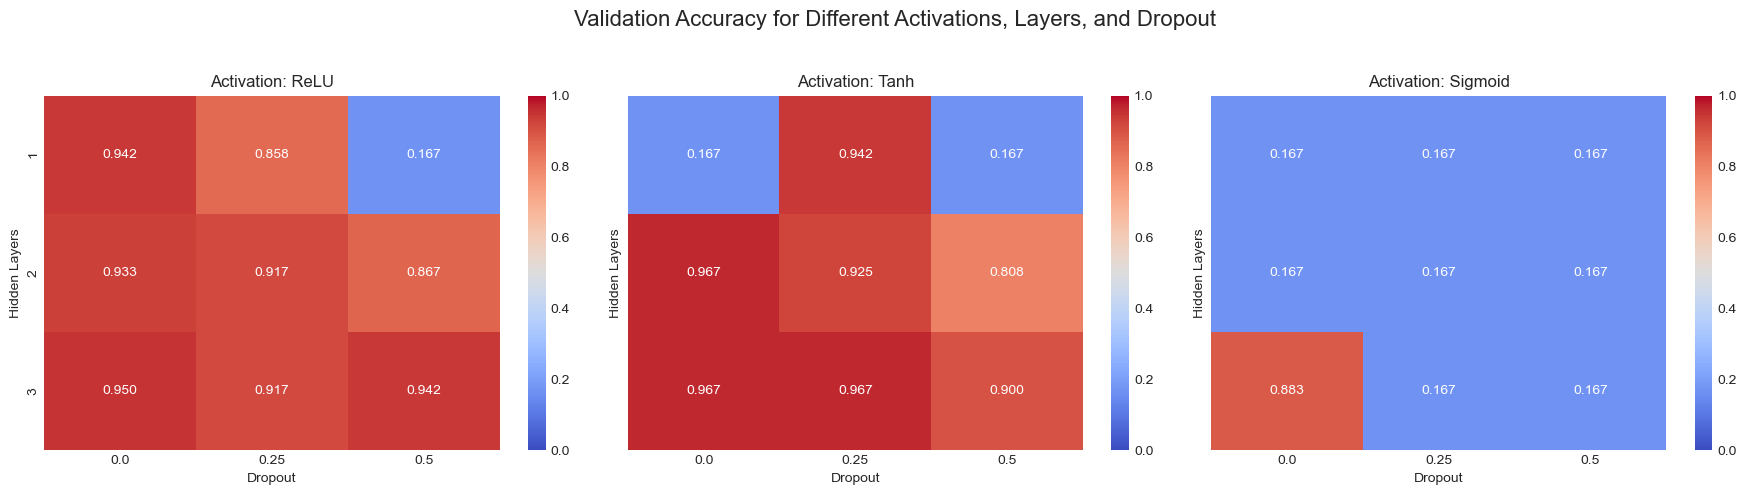

In [ ]:
import seaborn as sns

relu_df = results_df[results_df['activation']=='relu']
sigmoid_df = results_df[results_df['activation']=='sigmoid']
tanh_df = results_df[results_df['activation']=='tanh']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
vmin, vmax = 0.0, 1.0

for ax, (df, title) in zip(
    axes,
    [
        (relu_df, 'ReLU'),
        (tanh_df, 'Tanh'),
        (sigmoid_df, 'Sigmoid')
    ]
):
    pivot = df.pivot(index='hidden_layers', columns='dropout', values='val_accuracy')
    sns.heatmap(
        pivot,
        annot=True, fmt=".3f",
        cmap='coolwarm',
        vmin=vmin, vmax=vmax,
        ax=ax
    )
    ax.set_title(f'Activation: {title}')
    ax.set_xlabel('Dropout')
    ax.set_ylabel('Hidden Layers')

plt.suptitle('Validation Accuracy for Different Activations, Layers, and Dropout', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Підсумок експериментального блоку

**1. Функція активації:**
- Найкращі результати зазвичай давала активація ReLU, особливо для 2-3 шарових моделей.
- Tanh та sigmoid поступались ReLU за точністю, sigmoid часто давала найгірші результати, особливо на глибших мережах.
- Для sigmoid характерна повільніша збіжність і нижча якість на валідації.

**2. Dropout:**
- Dropout=0.0 призводив до переобучення, особливо на глибших моделях.
- Dropout=0.2–0.5 допомагав уникати переобучення, але занадто високий Dropout (0.5) іноді знижував якість через втрату інформації.
- Оптимальне значення Dropout залежить від глибини мережі: для 1-2 шарів достатньо 0.2, для 3 шарів — 0.25–0.5.

**3. Загальні спостереження:**
- Найкращі результати досягались для моделей з 2-3 шарами, активацією ReLU та Dropout 0.2–0.25.
- Моделі з sigmoid майже завжди поступались за точністю.
- Час навчання збільшувався з глибиною мережі, але не завжди це давало приріст точності.

**4. Цікаві моменти:**
- Деякі конфігурації з великою кількістю шарів і низьким Dropout швидко переобучались — train accuracy була значно вищою за validation accuracy.
- Для моделей з tanh іноді спостерігався "плато" — точність майже не змінювалась із збільшенням шарів.
- Dropout=0.5 був надто агресивним для неглибоких моделей.

### Загальний висновок

Оптимальна архітектура для цієї задачі — 2-3 згорткових шари з активацією ReLU та Dropout 0.2–0.25. Надмірна глибина або занадто великий Dropout не дають додаткових переваг і можуть навіть погіршити результат.